In [2]:
from llama_cpp import Llama
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import torch
from torch.nn import functional as F

In [3]:
model_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/vicuna-13B-1.1-GPTQ-4bit-128g-GGML/vicuna-13B-1.1-GPTQ-4bit-32g.GGML.bin"

LLM = Llama(model_path=model_bin, n_ctx=2048, n_threads=7, use_mmap=False, n_batch=512)

llama.cpp: loading model from /media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/vicuna-13B-1.1-GPTQ-4bit-128g-GGML/vicuna-13B-1.1-GPTQ-4bit-32g.GGML.bin
llama_model_load_internal: format     = ggjt v1 (latest)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 2048
llama_model_load_internal: n_embd     = 5120
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 40
llama_model_load_internal: n_layer    = 40
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 4 (mostly Q4_1, some F16)
llama_model_load_internal: n_ff       = 13824
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 13B
llama_model_load_internal: ggml ctx size = 9934493.73 KB
llama_model_load_internal: mem required  = 11749.65 MB (+ 1608.00 MB per state)
....................................................................................................
llama_init_from_file: kv s

In [4]:
def get_logits_and_probs(prompt):
    tokens = LLM.tokenize(prompt.encode('utf-8'))
    LLM.reset()
    LLM.eval(tokens)
    logits = LLM._logits()
    logits = np.array(logits[0])
    probs=F.softmax(torch.from_numpy(logits)).numpy()
    return logits, probs

In [5]:
def plot_logits(logits, bins=50):
    counts, bins = np.histogram(logits, bins=bins)
    plt.stairs(counts, bins)
    plt.title('Histogram of logits')

In [6]:
def plot_probs(probs, bins=1000, bins_to_skip=2):
    counts, bins = np.histogram(probs, bins=bins)
    # Observing that the vast majority of tokens are in the first bin, i.e. have incredibly small probability.
    print('There are {} tokens outside the {} smallest bins.'.format(len(np.where(probs>bins[bins_to_skip])[0]), bins_to_skip))
    # Don't plot the smallest bins since they are not interesting and dwarf all other bins
    plt.stairs(counts[bins_to_skip:], bins[bins_to_skip:])
    plt.title('Histogram of Token Probabilities')

In [7]:
def plot_most_likely_tokens(probs, num_tokens_to_plot=10):
    ind = np.argpartition(probs, -num_tokens_to_plot)[-num_tokens_to_plot:]

    likely_tokens = []
    token_probs = []

    for token in ind:
        c_token = [(ctypes.c_int)(*[token])]
        print('Token: {}, Prob: {}'.format(LLM.detokenize(c_token), probs[token]))
        # print('Token: {} Detokenized: {}'.format(token, LLM.detokenize(c_token)))
        likely_tokens.append(LLM.detokenize(c_token))
        token_probs.append(probs[token])

    plt.bar(likely_tokens, token_probs)
    plt.title('Bar chart of 10 most likely tokens')

HUMAN: You are to act as a verbal command parser on the bridge of a star ship from the Star Trek series.
You will be given a command spoken by the captain of the ship. 

You must determine which command is meant by the input. The possible outputs are [SET HEADING, SET SPEED, GET ENGINE STATUS, GET SPEED, GET HEADING, UNKNOWN]

If the command is nonsensical, unclear, or null, then output "UNKNOWN".

Respond with the command most appropriate command for the given input.

Input:
Full stop, John
ASSISTANT:


/tmp/ipykernel_1622578/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


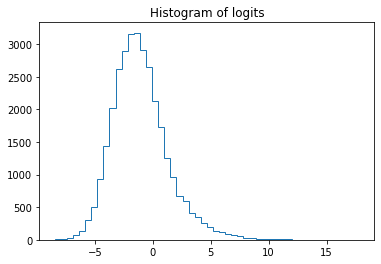

There are 24 tokens outside the 2 smallest bins.


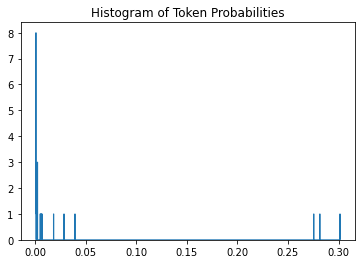

Token: b' U', Prob: 0.0049072278888443194
Token: b' "', Prob: 0.005528442273893844
Token: b' HE', Prob: 0.006076538701255359
Token: b' UN', Prob: 0.2756643507994488
Token: b' SET', Prob: 0.30163064269642453
Token: b' Set', Prob: 0.028466953942357775
Token: b' C', Prob: 0.006886382201628722
Token: b' Un', Prob: 0.0182842962678567
Token: b' Get', Prob: 0.03925159020684542
Token: b' GET', Prob: 0.2814935479874734


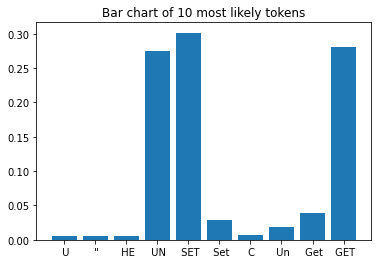

In [8]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
#command = "Bring us to full stop, John."
command = "Full stop, John"
#command = "I love jelly!"
#command = "John, I love jelly!"
#command = "Set the jelly, John!"
#command = "Jelly set bongus heading."
#command = "Warp 3. Engage."
#command = "What's our current heading?"

prompt = """HUMAN: You are to act as a verbal command parser on the bridge of a star ship from the Star Trek series.
You will be given a command spoken by the captain of the ship. 

You must determine which command is meant by the input. The possible outputs are [SET HEADING, SET SPEED, GET ENGINE STATUS, GET SPEED, GET HEADING, UNKNOWN]

If the command is nonsensical, unclear, or null, then output \"UNKNOWN\".

Respond with the command most appropriate command for the given input.

Input:
{}
ASSISTANT:""".format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

HUMAN: You are to act as a verbal command parser on the bridge of a star ship from the Star Trek series.
You will be given a command spoken by the captain of the ship. 

The command is specifying a heading for the ship. You must output one of the following values [ABSOLUTE, RELATIVE, UNKNOWN]

If the heading is absolute, such as 157 mark 250, return "ABSOLUTE". If the heading is relative, such as reversing course, then output "RELATIVE".

If the command is nonsensical, unclear, or null, then output "UNKNOWN".

Respond with the command most appropriate command for the given input.

Input:
Bring us about for a moment.
ASSISTANT:


/tmp/ipykernel_1622578/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


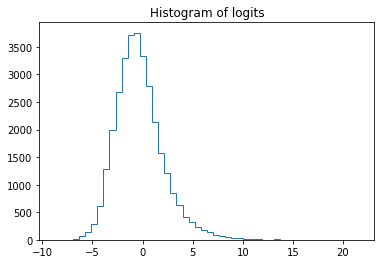

There are 7 tokens outside the 2 smallest bins.


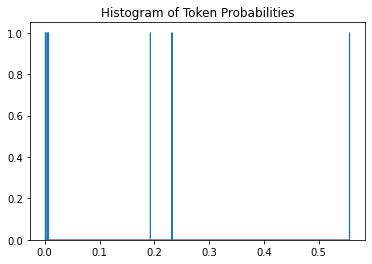

Token: b' relative', Prob: 0.00021094159552654775
Token: b' Re', Prob: 0.0014870391357755617
Token: b' Rel', Prob: 0.0020414075702115185
Token: b' Un', Prob: 0.004557014353347458
Token: b' A', Prob: 0.19292614804117542
Token: b' U', Prob: 0.0002736063089367334
Token: b' RE', Prob: 0.556259548429474
Token: b' UN', Prob: 0.2321680410203629
Token: b' "', Prob: 0.007169518075817283
Token: b' B', Prob: 0.00044983408401003025


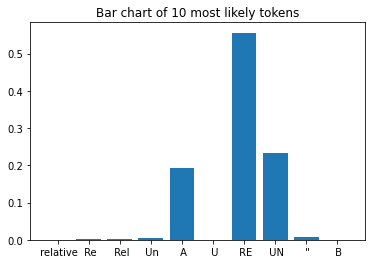

In [9]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
command = "Bring us about for a moment."
#command = "Bring us to full stop, John."
#command = "Full stop, John"
#command = "I love jelly!"
#command = "John, I love jelly!"
#command = "Set the jelly, John!"
#command = "Jelly set bongus heading."
#command = "Warp 3. Engage."

prompt = """HUMAN: You are to act as a verbal command parser on the bridge of a star ship from the Star Trek series.
You will be given a command spoken by the captain of the ship. 

The command is specifying a heading for the ship. You must output one of the following values [ABSOLUTE, RELATIVE, UNKNOWN]

If the heading is absolute, such as 157 mark 250, return \"ABSOLUTE\". If the heading is relative, such as reversing course, then output \"RELATIVE\".

If the command is nonsensical, unclear, or null, then output \"UNKNOWN\".

Respond with the command most appropriate command for the given input.

Input:
{}
ASSISTANT:""".format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

HUMAN: You are to act as a statement classifier on the bridge of a star ship from the Star Trek series.
You will be given a statement spoken by the captain of the ship. 

You must classify the input statement. The possible classifications are [REMARK, QUESTION, COMMAND]

Answer "REMARK" if the statement is a declarative observation such as "This is a dangerous situation."
Answer "QUESTION" if the statement is a question such as "What's our current heading?".
Answer "COMMAND" if the statement is a command, such as a "Set our heading to 120 mark 220."

Respond with the most probable classification for the given input statement.

Input:
What's our current heading?
ASSISTANT:


/tmp/ipykernel_1622578/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


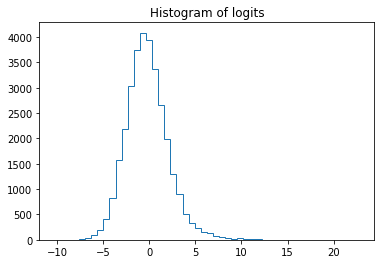

There are 1 tokens outside the 2 smallest bins.


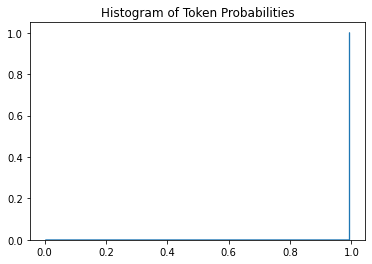

Token: b' This', Prob: 7.898069193955969e-05
Token: b' MAR', Prob: 8.02252984526576e-05
Token: b' CO', Prob: 9.084945174436832e-05
Token: b' A', Prob: 0.0006876475379584764
Token: b' RE', Prob: 0.0010968861133658116
Token: b' Q', Prob: 0.9943910591729165
Token: b' Question', Prob: 0.001222215190586313
Token: b' COM', Prob: 0.000782898311429332
Token: b' "', Prob: 0.0007457185579240362
Token: b' question', Prob: 0.00010103894347063447


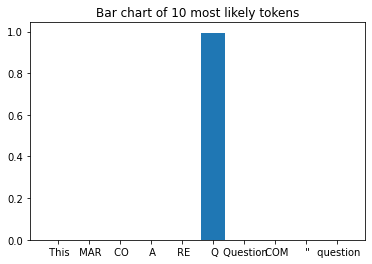

In [10]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
#command = "Bring us to full stop, John."
#command = "Full stop, John."
#command = "I love jelly!"
#command = "John, I love jelly!"
#command = "Set the jelly, John!"
#command = "Jelly set bongus heading."
#command = "Warp 3. Engage."
command = "What's our current heading?"

prompt = """HUMAN: You are to act as a statement classifier on the bridge of a star ship from the Star Trek series.
You will be given a statement spoken by the captain of the ship. 

You must classify the input statement. The possible classifications are [REMARK, QUESTION, COMMAND]

Answer \"REMARK\" if the statement is a declarative observation such as "This is a dangerous situation."
Answer \"QUESTION\" if the statement is a question such as "What's our current heading?".
Answer \"COMMAND\" if the statement is a command, such as a "Set our heading to 120 mark 220."

Respond with the most probable classification for the given input statement.

Input:
{}
ASSISTANT:""".format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

HUMAN: You are to act as a statement classifier on the bridge of a star ship from the Star Trek series.
You will be given a statement spoken by the captain of the ship. 

You must classify the INPUT. The possible classifications are [QUESTION, OTHER]

Answer "QUESTION" if the INPUT is QUESTION such as "What's our current heading?".
Answer "OTHER" if the INPUT is OTHER, such as a "Set our heading to 120 mark 220."

Output the most probable classification for the INPUT.

INPUT:
Warp 3. Engage.
ASSISTANT:


/tmp/ipykernel_1622578/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


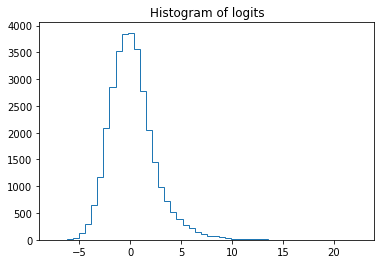

There are 4 tokens outside the 2 smallest bins.


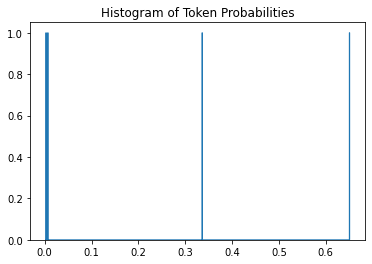

Token: b' R', Prob: 9.651233189575116e-05
Token: b' Ot', Prob: 0.00015338198477215105
Token: b' The', Prob: 0.00018502334146851553
Token: b' W', Prob: 0.00021988688410202578
Token: b' O', Prob: 0.33634386406997485
Token: b' "', Prob: 0.00031510441275156613
Token: b' Other', Prob: 0.006797138621382653
Token: b' It', Prob: 0.00024530692594638986
Token: b' Question', Prob: 0.0026680192078675524
Token: b' Q', Prob: 0.6512372012564257


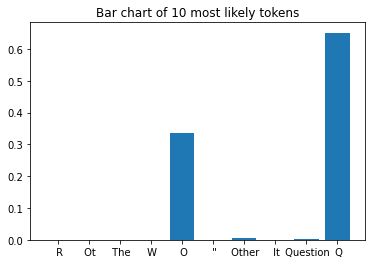

In [24]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
#command = "Bring us to full stop, John."
#command = "Full stop, John."
#command = "I love jelly!"
#command = "John, I love jelly!"
#command = "Set the jelly, John!"
#command = "Jelly set bongus heading."
command = "Warp 3. Engage."
#command = "What's our current heading?"

prompt = """HUMAN: You are to act as a statement classifier on the bridge of a star ship from the Star Trek series.
You will be given a statement spoken by the captain of the ship. 

You must classify the INPUT. The possible classifications are [QUESTION, OTHER]

Answer "QUESTION" if the INPUT is QUESTION such as "What's our current heading?".
Answer "OTHER" if the INPUT is OTHER, such as a "Set our heading to 120 mark 220."

Output the most probable classification for the INPUT.

INPUT:
{}
ASSISTANT:""".format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

HUMAN: Answer YES if the phrase is a question such as "What's our current heading?". Answer NO if the phrase is not a question, such as a "Set our heading to 120 mark 220."
PHRASE: Do you play the bongos?
ASSISTANT: YES
HUMAN: Answer YES if the phrase is a question such as "What's our current heading?". Answer NO if the phrase is not a question, such as a "Set our heading to 120 mark 220."
PHRASE: Hey, grab the binkies.
ASSISTANT: NO
HUMAN: Answer YES if the phrase is a question such as "What's our current heading?". Answer NO if the phrase is not a question, such as a "Set our heading to 120 mark 220."
PHRASE: What's our current heading?
ASSISTANT: 


/tmp/ipykernel_1622578/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


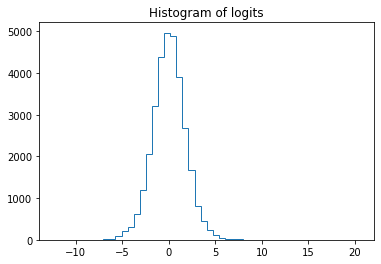

There are 11 tokens outside the 2 smallest bins.


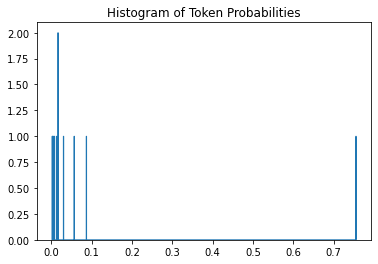

Token: b'\n', Prob: 0.003980216930385246
Token: b'4', Prob: 0.008272636795159917
Token: b'3', Prob: 0.01320212352170436
Token: b'7', Prob: 0.006744438368892054
Token: b'8', Prob: 0.016790900984963913
Token: b'2', Prob: 0.030649931296602838
Token: b'9', Prob: 0.01719698886782115
Token: b'6', Prob: 0.05679107770033627
Token: b'0', Prob: 0.08727456783814738
Token: b'1', Prob: 0.7558262658245731


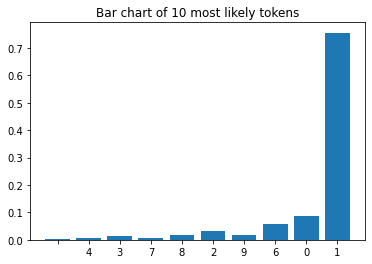

In [12]:
#command = "Don't do anything, John!"
#command = "John, beegle freegle, would ya?"
#command = "John, set the heading to 150 mark 190."
#command = "Bring us around, John! Reverse course!"
#command = "Bring us to full stop, John."
#command = "Full stop, John."
#command = "I love jelly!"
#command = "John, I love jelly!"
#command = "Set the jelly, John!"
#command = "Jelly set bongus heading."
#command = "Warp 3. Engage."
#command = "Does your planet have toilets?"
command = "What's our current heading?"

prompt = """HUMAN: Answer YES if the phrase is a question such as "What's our current heading?". Answer NO if the phrase is not a question, such as a "Set our heading to 120 mark 220."
PHRASE: Do you play the bongos?
ASSISTANT: YES
HUMAN: Answer YES if the phrase is a question such as "What's our current heading?". Answer NO if the phrase is not a question, such as a "Set our heading to 120 mark 220."
PHRASE: Hey, grab the binkies.
ASSISTANT: NO
HUMAN: Answer YES if the phrase is a question such as "What's our current heading?". Answer NO if the phrase is not a question, such as a "Set our heading to 120 mark 220."
PHRASE: {}
ASSISTANT: """.format(command)
print(prompt)
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()